In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import os 
from model.SimCLR import SimCLR
from model.Train import Trainer
from model.Losses import NTXentLoss
from utils.DataLoaderSimCLR import DataLoaderSimCLR as DSC
from utils.DataLoaderTest import DataLoaderTest as DLT
from torch.utils.data import DataLoader, random_split
from utils.Similarity import Similarity as SMY
from utils.Plotter import Plotter as PL

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\halim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
torch.cuda.empty_cache()

In [5]:
SSH = os.getcwd() != 'c:\\Cours-Sorbonne\\M1\\Stage\\src'

In [6]:
path_rol_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed" 
path_rol_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_super_compressed" 
path_rol_ht_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_ht_super_compressed" 
path_sim_rol_extracted_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/similaires_rol_extracted_nn_compressed" 
path_filtered = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed/json_filtered"
path_targets = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_sim_rol_triplets/targets.npy"
bad_pairs_path = "C:/Cours-Sorbonne/M1/Stage/src/files/bad_pairs.txt", 
to_enhance_path = "C:/Cours-Sorbonne/M1/Stage/src/files/to_enhance_pairs.txt",
path_sim_rol_test = "C:/Cours-Sorbonne/M1/Stage/src/data/data_PPTI/sim_rol_test"

if SSH:
    path_rol_ht_super_comp = "../data/rol_ht_super_compressed" 
    path_rol_comp = "../data/rol_super_compressed" 
    path_sim_rol_extracted_comp = "../data/sim_rol_super_compressed" 
    path_filtered = "../data/rol_super_compressed/json_filtered"
    path_sim_rol_test = "../data/sim_rol_test"
    path_targets = "../data/rol_sim_rol_couples/targets.npy"
    bad_pairs_path = "./files/bad_pairs.txt"
    to_enhance_path = "./files/to_enhance_pairs.txt"

## Params

In [7]:
epochs = 50
image_size = 256
batch_size = 32
learning_rate = 1e-3
train_ratio = 0.8
val_ratio = 0.2
temperature = 0.5

In [8]:
dataset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered, 
    shape=(image_size, image_size), target_path=path_targets, 
    remove_bad_pairs=True, remove_to_enhance_files=True, 
    augment_test=False, use_only_rol=True, use_context=True, max_images=10000
)

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)

[INFO] Using ROL Dataset with 9910 images
[INFO] Loaded exsisting targets


a black and white photo of people in a crowded street
a dark and white people of photo in a crowded street
a group of people standing around a grave
a radical amp of people standing around a grave


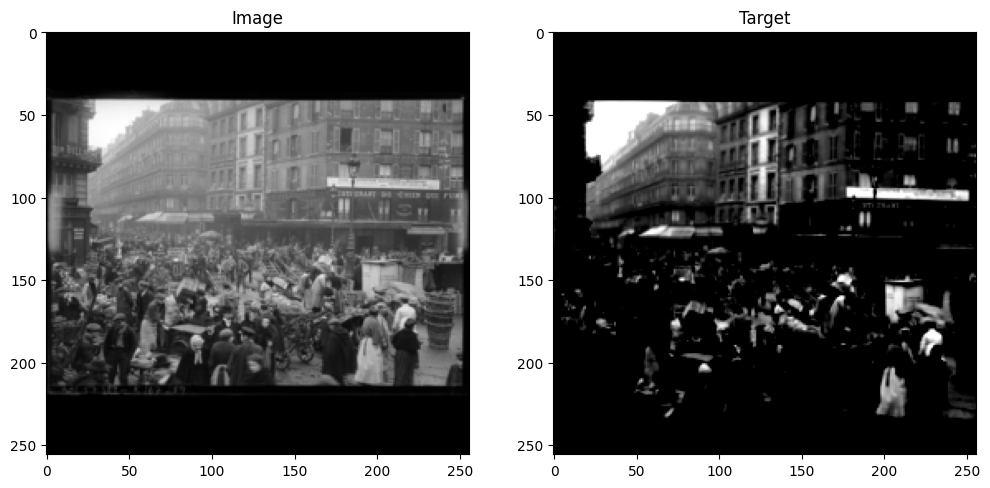

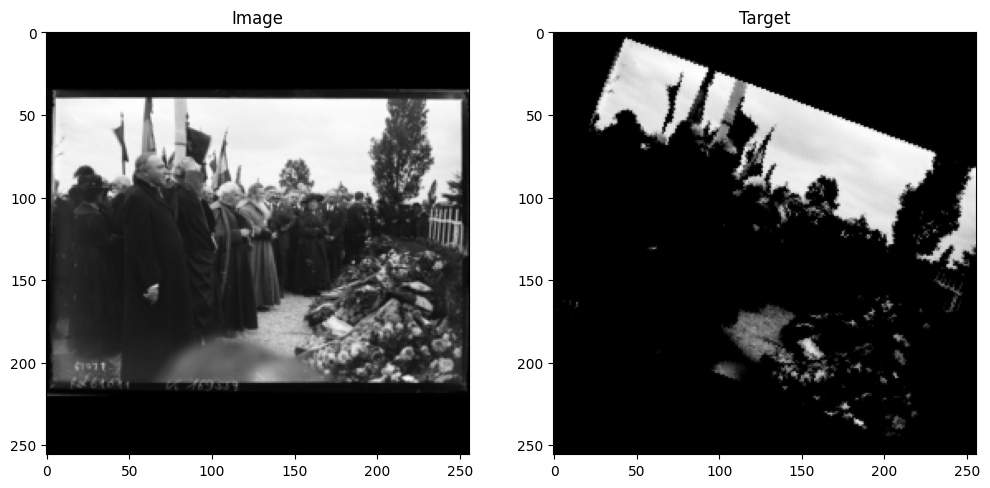

a man in a suit and tie sitting at a desk
affiliation a man in a suit and tie model at a desk
a group of people in a boat on the water
water group of citizenry in a boat on the a


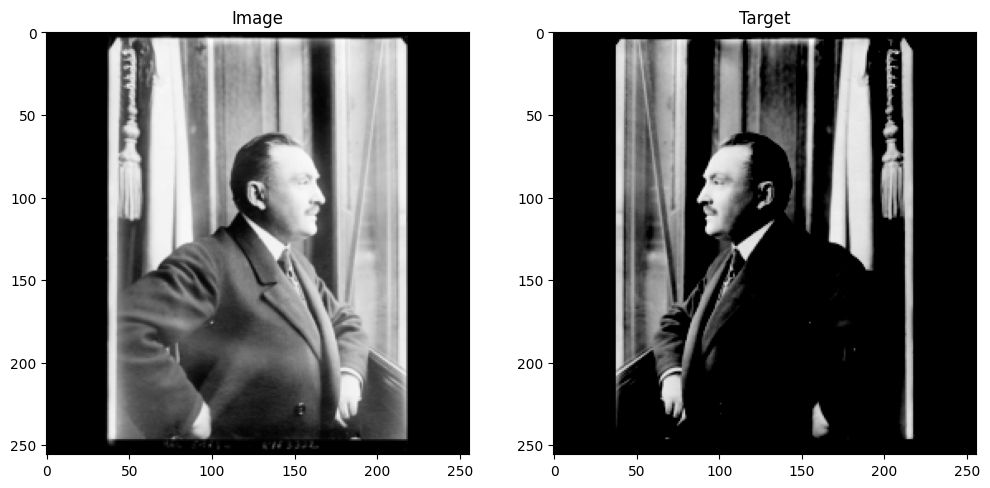

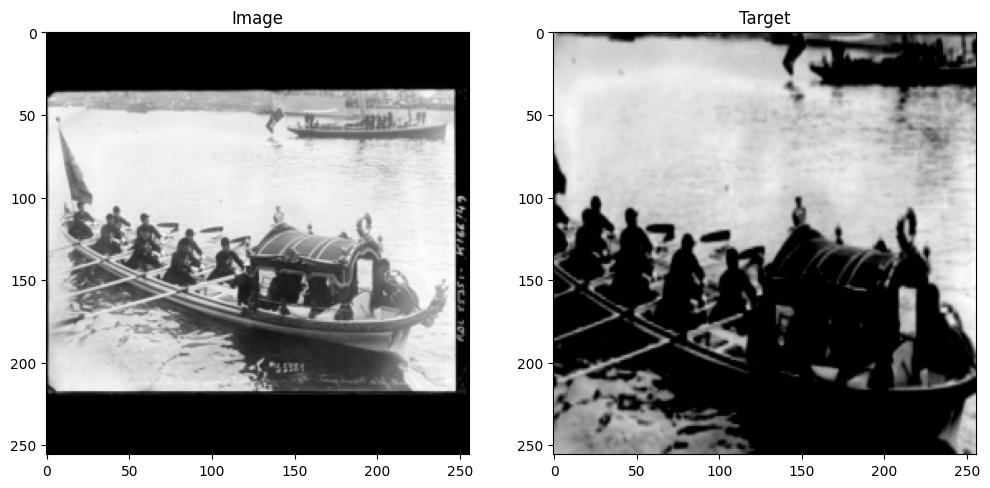

In [9]:
DSC.show_data(train_loader,2,use_context=True)
DSC.show_data(val_loader,2,use_context=True)

# Approche Supervisé

In [ ]:
model = SimCLR(feature_size=128)
optimizer = torch.optim.AdamW
loss_fn = NTXentLoss(temperature=temperature)

In [ ]:
trainer = Trainer()
trainer.set_model(model, "SimCLR-128") \
.set_optimizer(optimizer) \
.set_loss(loss_fn) 

model = trainer.fit(
    train_data=train_loader, validation_data=val_loader, learning_rate=learning_rate, 
    verbose=True, epochs=epochs, sim_clr=True, use_context=True
)

In [ ]:
trainer.save("model_simclr.pth","history_simclr.txt")

## Testing

In [ ]:
testset = DLT(path_sim_rol_test)

In [ ]:
test_loader = DataLoader(testset, batch_size=8, shuffle=True)
DSC.show_data(test_loader, 3)

In [ ]:
model = SimCLR(feature_size=128)
model_state = Trainer().get_model("./params/model/model_simclr.pth")
model.load_state_dict(model_state)
history = Trainer().get_history("./params/model/history_simclr.txt")

In [ ]:
top_k_pairs, original_images, augmented_images = SMY.match_images_with_simCLR(model, test_loader=test_loader, use_context=False, k=10, use_sift=True, is_test=True)

In [ ]:
best_pairs = top_k_pairs[:,0]
PL.plot_best_pairs(best_pairs, original_images, augmented_images, max_images=10)